<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/bayes/bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Statistics (Unfinished)


In [0]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os



In [3]:
# We borrow material from "Bayesian Analysis with Python (2nd end)" by Osvaldo Martin
#https://github.com/aloctavodia/BAP

!pip install pymc3
import pymc3 as pm


In [4]:
pip install arviz
import arviz as az

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 47.5MB/s 
     |████████████████████████████████| 327kB 49.6MB/s 


## Exact Bayesian inference for Beta-Binomial model



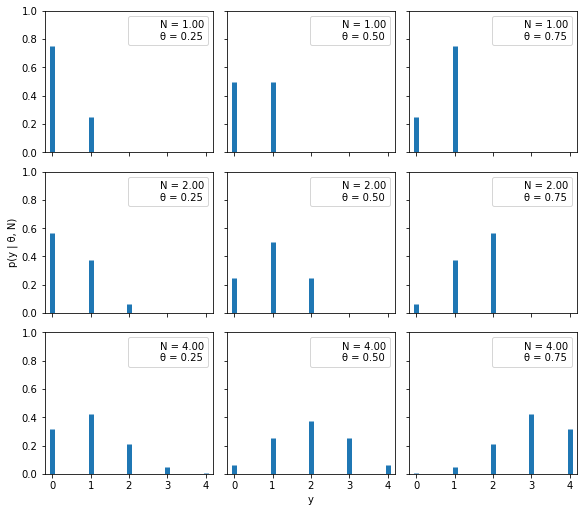

In [8]:
# Plot the Binomial likelihood

n_params = [1, 2, 4]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success

x = np.arange(0, max(n_params)+1)
f,ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = stats.binom(n=n, p=p).pmf(x)

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()

        ax[2,1].set_xlabel('y')
        ax[1,0].set_ylabel('p(y | θ, N)')
        ax[0,0].set_xticks(x)


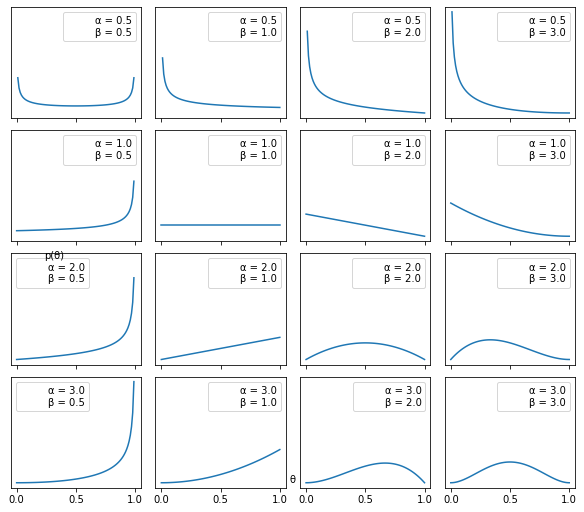

In [9]:
# Plot the beta prior

params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True,
                     figsize=(8, 7), constrained_layout=True)
for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)


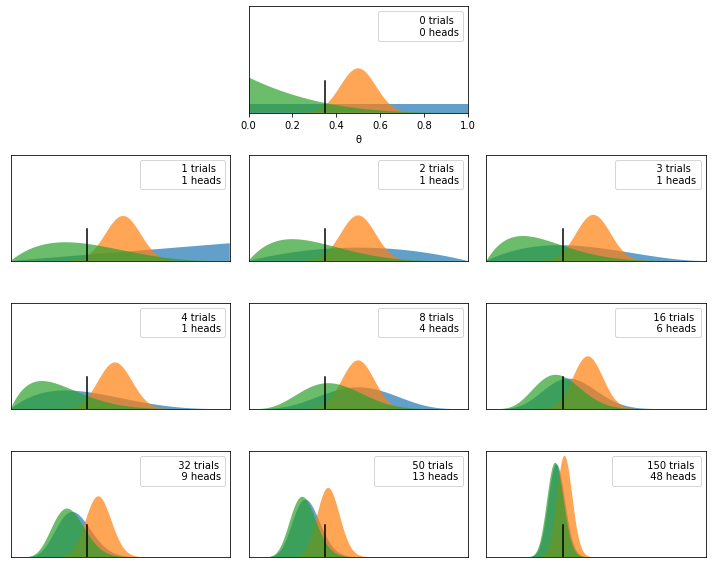

In [10]:
# Compute and plot posterior (black vertical line = true parameter value)

plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
dist = stats.beta
x = np.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()


## Credible intervals <a class="anchor" id="credible"></a>




In [24]:
# We illustrate how to compute a 95% posterior credible interval for a random variable
# with a beta distribution.

from scipy.stats import beta

np.random.seed(42)

N1 = 20; N0 = 80; N = N0 + N1 # Sufficient statistics
aprior = 1; bprior = 1; # prior
apost = aprior + N1; bpost = bprior + N0 # posterior

# Interval function
alpha = 0.05
CI1 = beta.interval(1-alpha, apost, bpost)
print('{:0.2f}--{:0.2f}'.format(CI1[0], CI1[1])) # (0.06:0.52) 

# Use the inverse CDF (percent point function)
l  = beta.ppf(alpha/2, apost, bpost)
u  = beta.ppf(1-alpha/2, apost, bpost)
CI2 = (l,u)
print('{:0.2f}--{:0.2f}'.format(CI2[0], CI2[1])) # (0.06:0.52) 

# Use Monte Carlo sampling
samples = beta.rvs(apost, bpost, size=10000)
samples = np.sort(samples)
CI3 = np.percentile(samples, 100*np.array([alpha/2, 1-alpha/2])) 
print('{:0.2f}--{:0.2f}'.format(CI3[0], CI3[1])) # (0.06:0.51) 
print(np.mean(samples))


0.13--0.29
0.13--0.29
0.13--0.29
0.20553262690907873


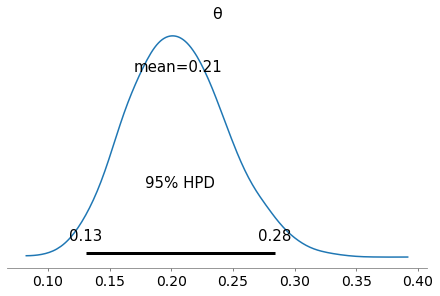

In [26]:
# The arviz package (https://github.com/arviz-devs/arviz) can be used to make plots
# of high posterior density intervals, as shown below.
# By default, it shows the 94\% interval, but we change it to 95%.
#np.random.seed(1)
#samples = stats.beta.rvs(5, 11, size=1000)
az.plot_posterior({'θ':samples}, credible_interval=0.95);

